# Analysis of high-street vacancy rates in several cities using simulated data 
This script engineers a feature - the "relative vacancy rate" - that describes the economic performance of a particular property class (e.g., high-street retail) relative to a local average. It does so for several cities and models how relative vacancy rate responds in each when exposed to an economic shock.


# Motivation 
Vacancy rates serve as a useful indicator of economic health and the state of individual property classes such as retail. The risk in analysing these rates without a broader context is that one might falsely attribute trends, such as high-street vacancies, to sector-specific changes—like the rise of e-commerce—when in fact these could be due to broader economic forces affecting multiple property classes. A solution is to create a relative vacancy ratio that benchmarks vacancies for a property classe on interest against a local average. 

**Let's begin by loading in packages**

In [12]:
library(ggplot2)
library(dplyr)
library(tidyr)
library(data.table)
library(ggplot2)
library(RColorBrewer)
library(ggthemes)
library(ggsci)
library(mgcv)
library(ggpubr)


**Now we'll simulate 5 years of vacancy rate data for 4 property classes in 3 cities**

**We'll introduce an economic shock after two years that hits high-street retail hardest, especially in manchester**

In [2]:
# create parameters
n_years <- 5
n_months <- 12
n_cities <- 3
n_property_classes <- 4  # e.g., 1 = residential, 2 = commercial, 3 = high street retail, Industrial = 4


In [3]:
# create data frame to store simulated data
vacancy_data <- data.frame(
  year = integer(),
  month = integer(),
  city = factor(),
  property_class = factor(),
  vacancy_rate = numeric()
)

In [4]:
# generate data
set.seed(15) # first set seed
time_id <- 0
for (year in 1:n_years) {
  for (month in 1:n_months) {
    time_id <- time_id + 1
    for (city in 1:n_cities) {
      for (property_class in 1:n_property_classes) {
        
        # base vacancy rate
      
        base_vacancy_rate <- min(max(rnorm(1, mean = 5, sd = 1), 2), 8)

        
        # add economic shock after 2 years (24 time periods)
        economic_shock <- ifelse(time_id > 24 & time_id < 48, pmax(0, rnorm(1, 4, 1)), 0)
        
        # make the economic shock worse for manchester
        if (city == 3) {
          economic_shock <- economic_shock * 7  # 7 is an example multiplier but it could be anything
        }
        
        # add differential impact by property class
        if (property_class == 3) {
          economic_shock <- economic_shock * 2 
        } else {
          economic_shock <- economic_shock * 1
        }

        # final vacancy rate
        vacancy_rate <- base_vacancy_rate + economic_shock
        
        # store data
        vacancy_data <- rbind(vacancy_data, c(year, month, city, property_class, vacancy_rate))
        colnames(vacancy_data) <- c("year", "month", "city", "property_class", "vacancy_rate")

      }
    }
  }
}

**Now let's check that our data looks right**

In [5]:
# inspect first 5 rows
head(vacancy_data, 5)

,year,month,city,property_class,vacancy_rate
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,1,1,5.258823
2,1,1,1,2,6.831121
3,1,1,1,3,4.660381
4,1,1,1,4,5.897198
5,1,1,2,1,5.488016


In [6]:
# do we get the expected number of unique values in each col?
lapply(vacancy_data, function(x) length(unique(x)))

$year
[1] 5

$month
[1] 12

$city
[1] 3

$property_class
[1] 4

$vacancy_rate
[1] 719

**Now we'll do some feature engineering. for each city, we'll divide vacancy rates in high-street property by the average of the other local property classes, creating a relative vacancy ratio**

**Relative_vacancy_ratio interpretation:** 
* above 1 means high street vacnancy is above local benchmark
* below 1 means high street vacnancy is below local benchmark
* at 1 means high street vacnancy is the same (i.e., parity)

In [7]:
# we'll compute vancancy rate for each month in each city
vacancy_data1 <- vacancy_data %>% group_by(city, year, month) %>% 
  mutate(local_vacancy_rate_benchmark = mean(vacancy_rate[!property_class == 3]), 
         relative_vacancy_ratio = vacancy_rate[property_class == 3]/local_vacancy_rate_benchmark) %>%
  data.table()

# then we'll clean the dataset and set city names
vacancy_data2 <- vacancy_data1 %>% filter(property_class == 1) %>% 
  group_by(city) %>%
  mutate(time = seq(1, 60), 
         city = case_when(city == 1 ~ "London",
                          city == 2 ~ "Bristol",
                          city == 3 ~ "Manchester"))


**Let's visualise the distribution of relative_vacancy_ratio**

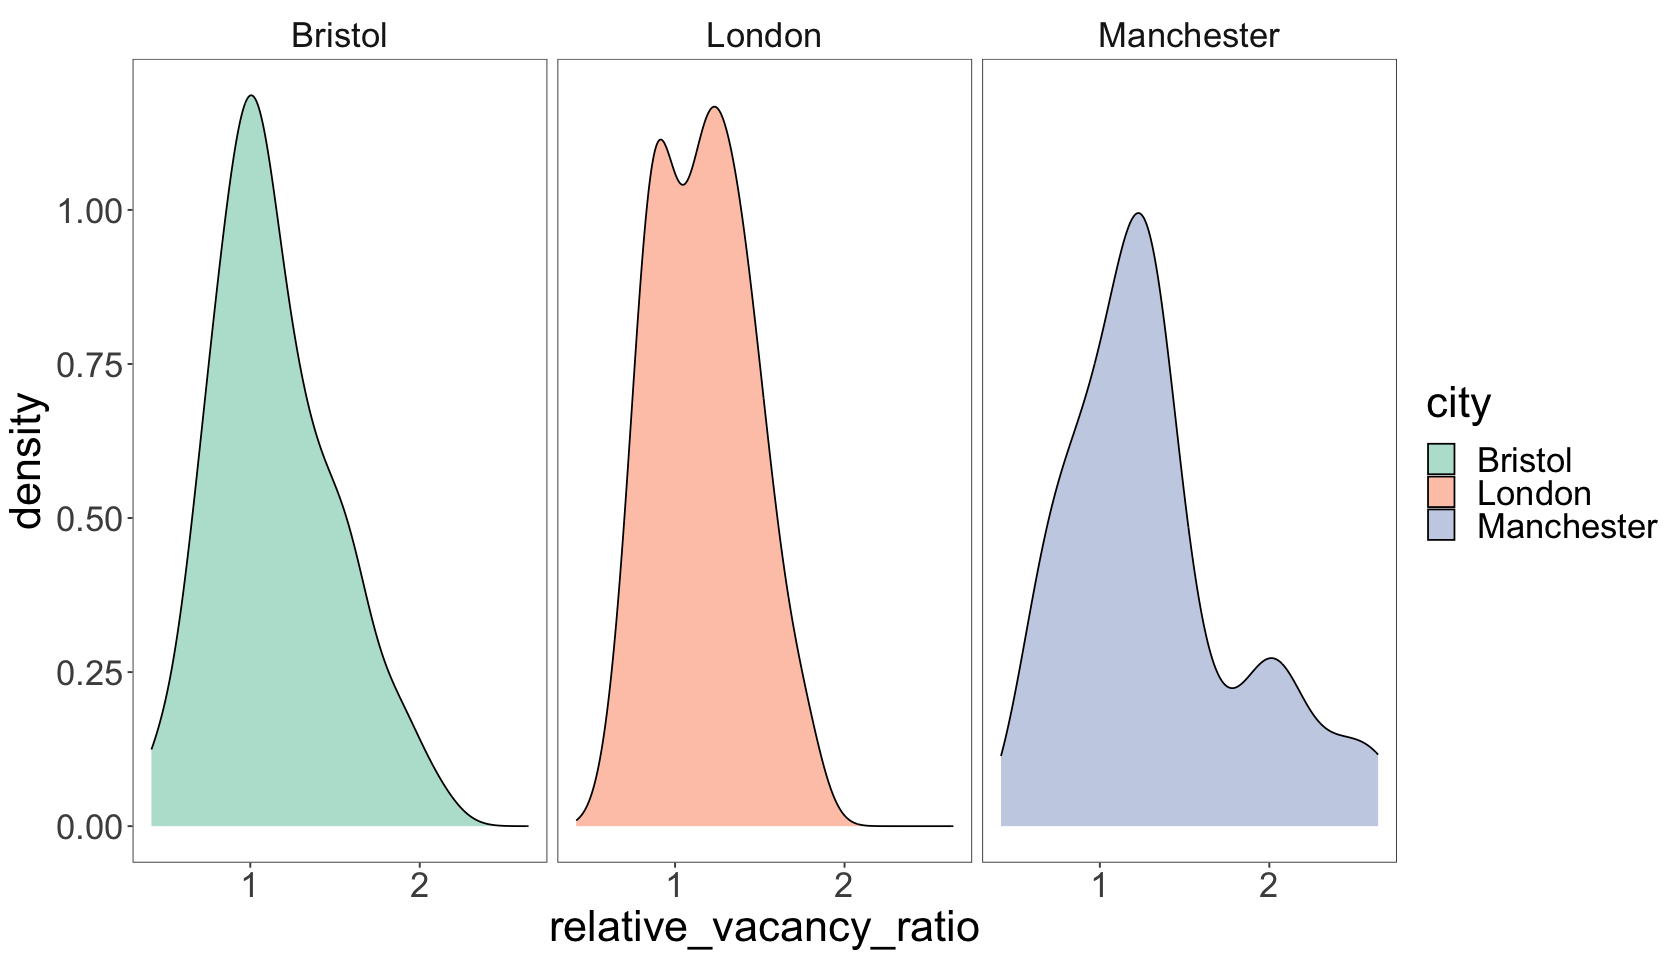

In [8]:
# adjust plot width
options(repr.plot.width=14, repr.plot.height=8)

vacancy_data2 %>% ggplot(aes(x = relative_vacancy_ratio, fill = city)) + 
geom_density(alpha = 0.5) +
scale_fill_brewer(name = "city", palette = "Set2") +
theme_few() +
theme(text = element_text(size = 26)) + 
facet_grid(~city)

**Now let's inspect it statistically**

In [9]:
vacancy_data2 %>% group_by(city) %>% 
summarise(mean = mean(relative_vacancy_ratio), sd = sd(relative_vacancy_ratio))

city,mean,sd
<chr>,<dbl>,<dbl>
Bristol,1.143979,0.3597094
London,1.167017,0.2810147
Manchester,1.321284,0.5152875


**Finally we'll create a plot visualising the change in high-street relative vacancy ratio by city**

`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'


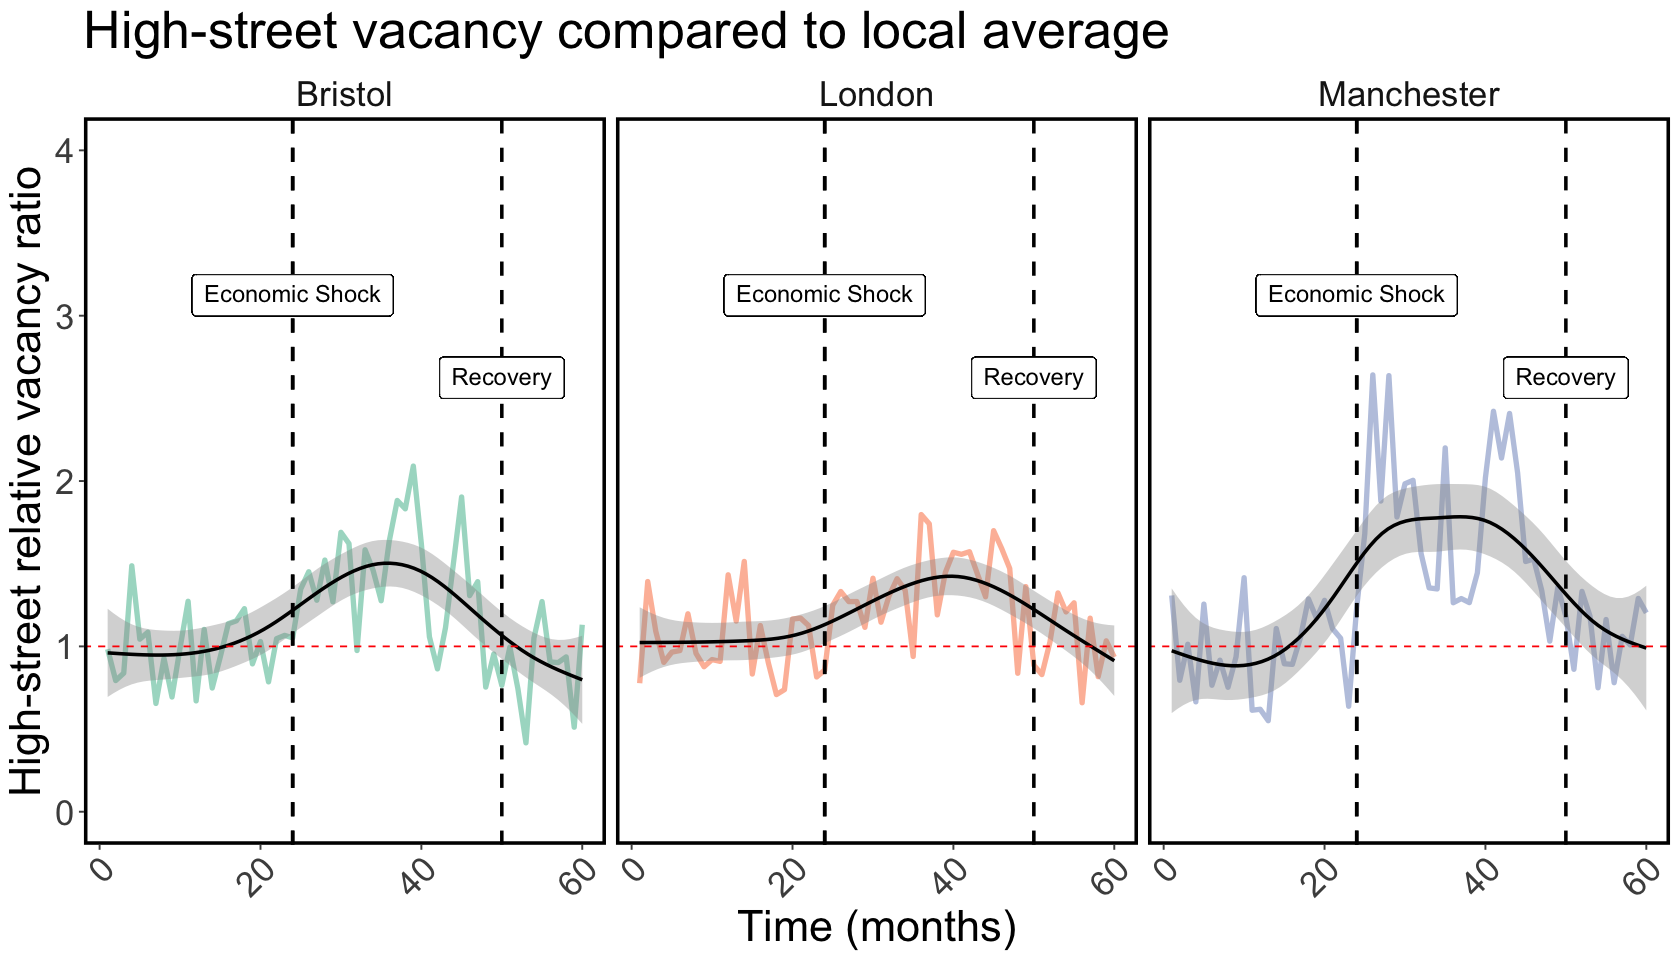

In [13]:
# create final plot
(plot <- ggplot(vacancy_data2, aes(x = time, y = relative_vacancy_ratio)) +
  geom_line(aes(color = city), alpha = 0.6, size = 1.5) +
  geom_smooth(se = TRUE, colour = "black", size = 1, method = "gam") +
  facet_grid(~ city) +
  ggtitle("High-street vacancy compared to local average")  +
  xlab("Time (months)") +
  theme_few() +
  scale_y_continuous(limits = c(0, 4), breaks = seq(0,4)) +
  geom_vline(xintercept = 24, linetype = "dashed", colour = "black", size = 1) +
  geom_hline(yintercept = 1, linetype = "dashed", colour = "red") +
  ylab("High-street relative vacancy ratio") +
  scale_color_brewer(name = "city", palette = "Set2") +
  theme(text = element_text(size = 26)) + 
  geom_vline(xintercept = 24, linetype = "dashed", colour = "black", size = 1) +
  geom_label(aes(x = 24, y = 3, label = "Economic Shock"), 
           angle = 90, vjust = 0, size = 5, 
           label.padding = unit(0.5, "lines"))+
   geom_vline(xintercept = 50, linetype = "dashed", colour = "black", size = 1) +
   geom_label(aes(x = 50, y = 2.5, label = "Recovery"), 
           angle = 90, vjust = 0, size = 5, 
           label.padding = unit(0.5, "lines"))+
 
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    legend.position = "NA",
      panel.border = element_rect(colour = "black", fill=NA, size=2)
  )
 )

**We can see that that economic shock increases vacancy rates on the high street relative to the local average and that this appears more pronounced in Manchester**

**But are these effects statistically significant? Let's fit a simple model to find out if the relative vacancy ratio is different in the pre- and post-shock environment and whether this varies by city**

In [11]:
# create an indicator for time period after the shock
vacancy_data2 <- vacancy_data2 %>% group_by(city) %>%
  mutate(post_shock = ifelse(time > 24, 1, 0))

# fit a linear regression with an interaction term for post-shock and city
its_model <- lm(relative_vacancy_ratio ~ post_shock*city, data=vacancy_data2)
summary(its_model)


Call:
lm(formula = relative_vacancy_ratio ~ post_shock * city, data = vacancy_data2)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.83380 -0.23675 -0.00085  0.19905  1.08745 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)                0.98427    0.07124  13.816  < 2e-16 ***
post_shock                 0.26618    0.09197   2.894  0.00429 ** 
cityLondon                 0.03678    0.10075   0.365  0.71551    
cityManchester            -0.01266    0.10075  -0.126  0.90012    
post_shock:cityLondon     -0.02290    0.13007  -0.176  0.86043    
post_shock:cityManchester  0.31662    0.13007   2.434  0.01594 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.349 on 174 degrees of freedom
Multiple R-squared:  0.271,	Adjusted R-squared:   0.25 
F-statistic: 12.94 on 5 and 174 DF,  p-value: 1.052e-10


**Interpretation: we can see that the shock significantly increases the relative vacancy ratio (p < 0.001) and that the effects are larger in Manchaster (p = 0.02)**